### Federated Fine-tuning for ASR
* Centralized: You fine-tune DistilHuBERT for downstream ASR tasks.
* FL: Simulate a federated ASR learning scenario where multiple clients (speakers) fine-tune a shared model on local speech data using FedAvg/FedOpt.

In [1]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [2]:
import torch
import copy
from datasets import load_from_disk
from transformers import (
    AutoProcessor,
    AutoModelForCTC,
    TrainingArguments,
    Trainer
)
from typing import List, Dict
from collections import defaultdict
from torch.utils.data import Dataset
import numpy as np
import random
import jiwer
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
dataset = load_from_disk("/scratch/pippalin2/jupyter/GMM-DistilHuBERT/processed_dataset")
dataset = dataset.train_test_split(test_size=0.1)
train_dataset = dataset["train"]
eval_dataset = dataset["test"]

Loading dataset from disk:   0%|          | 0/47 [00:00<?, ?it/s]

In [4]:
train_dataset

Dataset({
    features: ['input_values', 'labels'],
    num_rows: 25670
})

#### Simulating FL setting: clients

In [5]:
def split_into_clients_nonuniform(dataset, num_clients, min_frac, max_frac):
    size = len(dataset)

    proportions = np.random.uniform(min_frac, max_frac, size=num_clients)
    proportions = proportions / proportions.sum()
    sizes = (proportions * size).astype(int)

    # Ensure total size matches
    diff = size - sizes.sum()
    sizes[0] += diff

    # Client splits
    indices = np.arange(size)
    np.random.shuffle(indices)

    client_datasets = []
    start = 0
    for s in sizes:
        end = start + s
        client_datasets.append(dataset.select(indices[start:end].tolist()))
        start = end

    return client_datasets
client_datasets = split_into_clients_nonuniform(train_dataset, num_clients=20, min_frac=0.01, max_frac=0.1)

In [6]:
processor = AutoProcessor.from_pretrained("/scratch/pippalin2/jupyter/GMM-DistilHuBERT/processor")
base_model = AutoModelForCTC.from_pretrained("ntu-spml/distilhubert").to("cuda")

Some weights of HubertForCTC were not initialized from the model checkpoint at ntu-spml/distilhubert and are newly initialized: ['lm_head.bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
class DataCollatorCTCWithPadding:
    def __init__(self, processor, padding=True):
        self.processor = processor
        self.padding = padding

    def __call__(self, features: List[Dict]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_values": f["input_values"]} for f in features]
        label_features = [{"input_ids": f["labels"]} for f in features]

        batch = self.processor.feature_extractor.pad(input_features, padding=self.padding, return_tensors="pt")
        labels_batch = self.processor.tokenizer.pad(label_features, padding=self.padding, return_tensors="pt")
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels
        return batch

data_collator = DataCollatorCTCWithPadding(processor)


In [8]:
def local_finetune(model, dataset, processor, collator, compute_metrics, output_dir):
    training_args = TrainingArguments(
        output_dir="./FedAvg_checkpoints",
        per_device_train_batch_size=2,
        eval_strategy="no",
        num_train_epochs=2,
        eval_steps=400,
        logging_steps=10,
        save_steps=500,
        learning_rate=1e-4,
        fp16=True,
        resume_from_checkpoint=False,
        report_to="none"
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset,
        tokenizer=processor,
        data_collator=collator,
        compute_metrics=compute_metrics,
    )
    train_output = trainer.train()
    metrics = {
    "train_loss": train_output.training_loss,
    "train_steps": training_args.max_steps if training_args.max_steps else None,
    }
    return model.state_dict(), metrics

def fed_avg(state_dicts: List[Dict]):
    avg_dict = copy.deepcopy(state_dicts[0])
    for key in avg_dict:
        for i in range(1, len(state_dicts)):
            avg_dict[key] += state_dicts[i][key]
        avg_dict[key] = avg_dict[key] / len(state_dicts)
    return avg_dict

In [9]:
transform = jiwer.Compose([
    jiwer.ToLowerCase(),
    jiwer.RemovePunctuation(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.Strip(),
])

def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = torch.argmax(torch.tensor(pred_logits), dim=-1)

    # Decode predictions
    pred_str = processor.batch_decode(pred_ids)

    # Decode references
    label_ids = pred.label_ids
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, group_tokens=False)

    # Normalize
    pred_str = [transform(p) for p in pred_str]
    label_str = [transform(l) for l in label_str]

    # Compute metrics
    wer = jiwer.wer(label_str, pred_str)
    cer = jiwer.cer(label_str, pred_str)

    # Sentence Error Rate: fraction of sentences with at least 1 error
    ser = sum(p != l for p, l in zip(pred_str, label_str)) / len(label_str)

    return {
        "wer": wer,
        "cer": cer,
        "ser": ser,
    }


def evaluate_global_model(global_model, eval_dataset):
    eval_args = TrainingArguments(
        output_dir="./FedAvg_checkpoints/eval_temp",
        per_device_eval_batch_size=4,
        report_to="none",
        do_train=False,
        do_eval=True,
        dataloader_drop_last=False,
    )

    eval_trainer = Trainer(
        model=global_model,
        args=eval_args,
        tokenizer=processor.tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        eval_dataset=eval_dataset
    )

    results = eval_trainer.evaluate()
    print(f"Eval after round: WER={results['eval_wer']:.4f}, CER={results['eval_cer']:.4f}, SER={results['eval_ser']:.4f}")
    return results

In [10]:
global_model = deepcopy(base_model)
round_metrics = []

for round_num in range(10):
    print(f"Round {round_num + 1}")
    selected_clients = random.sample(client_datasets, k=5)
    weights = []
    client_losses = []

    for i, client_data in enumerate(selected_clients):
        print(f"Client {i+1} (data size: {len(client_data)})")
        local_model = copy.deepcopy(global_model)
        state, train_metrics = local_finetune(
            local_model,
            client_data,
            processor,
            data_collator,
            compute_metrics,
            f"./client{i}_round{round_num}"
        )
        weights.append(state)
        client_losses.append(train_metrics["train_loss"])

    # FedAvg
    avg_weights = fed_avg(weights)
    global_model.load_state_dict(avg_weights)

    # Evaluate global model for each iteration
    eval_metrics = evaluate_global_model(global_model, eval_dataset)
    round_metrics.append({
        "round": round_num + 1,
        "train_loss": sum(client_losses) / len(client_losses),
        "eval_loss": eval_metrics.get("eval_loss"),
        "eval_wer": eval_metrics.get("eval_wer"),
        "eval_cer": eval_metrics.get("eval_cer"),
        "eval_ser": eval_metrics.get("eval_ser"),
    })

    global_model.save_pretrained(f"./FedAvg_checkpoints/round{round_num+1}_global_model")

Round 1
Client 1 (data size: 309)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2218.662300
20,1182.677600
30,1109.000600
40,1096.000400
50,1113.170400
60,1066.201800
70,1081.207800


Client 2 (data size: 834)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2100.705100
20,1087.940500
30,1059.045300
40,1162.771400
50,1039.536400
60,1007.393600
70,1081.531000
80,1033.104400
90,1094.177700
100,1117.028700


Client 3 (data size: 2105)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2201.104100
20,1150.742600
30,1166.375900
40,1094.314000
50,1111.500800
60,1059.819200
70,1109.354800
80,1075.791000
90,1003.945000
100,1002.100200


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Client 4 (data size: 1804)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2211.679100
20,1176.314900
30,1058.910300
40,1024.782200
50,1118.320300
60,1031.918900
70,1018.212600
80,970.057700
90,1018.020700
100,1076.522100


Client 5 (data size: 313)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2268.843200
20,1164.797500
30,1070.936800
40,1000.446800
50,1107.101300
60,1032.597100
70,1056.641900
80,996.150100


/tmp/ipykernel_418300/1516574793.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=1.0000, CER=1.0000, SER=1.0000
Round 2
Client 1 (data size: 1004)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1102.559100
20,1039.106100
30,1030.384000
40,877.309900
50,859.567500
60,806.963300
70,771.173500
80,752.814500
90,671.036600
100,645.816700


Client 2 (data size: 1077)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1031.096600
20,988.471600
30,924.148300
40,868.515800
50,803.369600
60,749.401900
70,782.569300
80,692.837200
90,651.098200
100,651.055600


Client 3 (data size: 1029)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1036.174300
20,1091.899900
30,952.468000
40,919.883900
50,889.386300
60,756.978300
70,809.946800
80,678.153700
90,691.594900
100,637.700700


Client 4 (data size: 578)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1076.241800
20,1038.237200
30,966.694000
40,917.754700
50,877.849600
60,834.708300
70,771.713000
80,705.474800
90,710.024300
100,681.915700


Client 5 (data size: 2309)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1058.713100
20,1002.539800
30,900.498200
40,898.425100
50,799.334200
60,768.498700
70,706.342300
80,671.764800
90,614.153400
100,659.952300


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/tmp/ipykernel_418300/1516574793.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=0.8821, CER=0.3770, SER=1.0000
Round 3
Client 1 (data size: 1004)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,532.306700
20,508.593300
30,525.476600
40,459.685000
50,466.188500
60,465.007400
70,462.801300
80,470.875300
90,423.817200
100,420.769300


Client 2 (data size: 1077)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,510.189300
20,495.435700
30,478.833800
40,478.865100
50,454.171500
60,441.675300
70,471.511800
80,436.124500
90,416.257000
100,433.416100


Client 3 (data size: 1029)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,508.817400
20,525.396700
30,465.678400
40,472.020000
50,482.954100
60,442.700300
70,488.351100
80,419.909200
90,441.477000
100,418.105000


Client 4 (data size: 578)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,531.396300
20,501.929600
30,475.653700
40,474.633200
50,473.800600
60,470.062300
70,451.732800
80,412.667600
90,419.804700
100,414.272400


Client 5 (data size: 2309)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,516.053100
20,510.789700
30,473.522400
40,500.498500
50,454.537300
60,450.724800
70,436.001200
80,441.936500
90,400.468500
100,447.889500


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/tmp/ipykernel_418300/1516574793.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=0.7776, CER=0.2792, SER=1.0000
Round 4
Client 1 (data size: 1004)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,385.277600
20,388.773200
30,405.132100
40,357.513800
50,364.220400
60,376.069600
70,374.602300
80,386.693800
90,345.306200
100,344.348200


Client 2 (data size: 1077)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,374.189500
20,376.085100
30,370.279100
40,375.210400
50,358.402500
60,352.935100
70,376.737800
80,350.639900
90,339.302400
100,357.508400


Client 3 (data size: 1029)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,377.506800
20,398.666700
30,351.996700
40,367.651900
50,380.587900
60,354.183300
70,394.755500
80,342.716800
90,359.673800
100,346.791200


Client 4 (data size: 578)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,394.759400
20,382.036300
30,367.782300
40,372.394700
50,375.486200
60,373.174600
70,362.272500
80,329.188200
90,330.940100
100,330.608000


Client 5 (data size: 2309)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,382.454200
20,391.797300
30,365.545700
40,393.503600
50,355.824500
60,358.448500
70,349.858900
80,358.760100
90,325.439600
100,371.974500


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/tmp/ipykernel_418300/1516574793.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=0.7142, CER=0.2450, SER=1.0000
Round 5
Client 1 (data size: 1004)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,321.117200
20,334.974200
30,350.000300
40,309.912500
50,314.870700
60,330.945800
70,330.647000
80,343.233100
90,304.155000
100,303.670200


Client 2 (data size: 1077)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,311.574600
20,323.208400
30,318.172200
40,325.022600
50,311.841300
60,307.875100
70,330.819400
80,306.604700
90,298.254200
100,315.389700


Client 3 (data size: 1029)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,317.428800
20,339.747100
30,300.741100
40,316.835800
50,329.893700
60,308.722400
70,344.841900
80,301.549500
90,316.216900
100,307.514700


Client 4 (data size: 578)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,332.598700
20,326.662800
30,316.787300
40,320.868900
50,326.600400
60,324.392100
70,316.803900
80,284.249800
90,283.985100
100,286.085000


Client 5 (data size: 2309)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,321.217200
20,338.238900
30,316.686300
40,340.239500
50,306.462200
60,311.011600
70,305.471800
80,313.221500
90,286.652300
100,328.858900


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/tmp/ipykernel_418300/1516574793.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=0.6736, CER=0.2258, SER=1.0000
Round 6
Client 1 (data size: 1004)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,279.819200
20,301.272900
30,314.786500
40,278.302100
50,283.464300
60,301.106900
70,301.987200
80,314.533200
90,275.967200
100,276.831200


Client 2 (data size: 1077)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,271.330200
20,290.076100
30,284.856100
40,293.835300
50,279.580600
60,278.118700
70,299.653100
80,276.660600
90,270.399500
100,286.163300


Client 3 (data size: 1029)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,278.994800
20,303.034000
30,268.951700
40,285.564000
50,298.583100
60,278.568200
70,312.130200
80,272.486900
90,287.258600
100,281.365100


Client 4 (data size: 578)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,291.813700
20,290.854200
30,283.965600
40,287.654100
50,295.339700
60,294.631700
70,288.647500
80,255.051100
90,252.973800
100,257.058800


Client 5 (data size: 2309)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,280.146700
20,304.398400
30,284.759800
40,307.246300
50,274.973200
60,279.199100
70,275.212600
80,282.209400
90,260.419900
100,298.630000


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/tmp/ipykernel_418300/1516574793.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=0.6454, CER=0.2129, SER=1.0000
Round 7
Client 1 (data size: 1004)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,249.180600
20,276.882800
30,287.907700
40,254.514200
50,260.457500
60,278.792200
70,280.163500
80,292.475200
90,254.738100
100,256.395200


Client 2 (data size: 1077)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,240.847200
20,265.021900
30,259.883000
40,269.336400
50,255.923600
60,255.172200
70,274.788600
80,254.018300
90,248.496500
100,263.618900


Client 3 (data size: 1029)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,248.021800
20,275.162100
30,245.220600
40,261.756100
50,274.379300
60,255.715300
70,287.109300
80,250.853600
90,265.244700
100,261.699700


Client 4 (data size: 578)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,260.145000
20,264.442100
30,259.869800
40,262.762900
50,272.119700
60,272.929800
70,268.202200
80,232.991400
90,230.232900
100,235.196900


Client 5 (data size: 2309)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,248.599300
20,278.860800
30,259.928200
40,282.114200
50,251.635600
60,255.307400
70,252.274700
80,258.687500
90,240.279600
100,274.836900


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/tmp/ipykernel_418300/1516574793.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=0.6219, CER=0.2034, SER=1.0000
Round 8
Client 1 (data size: 1004)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,223.820500
20,257.553500
30,265.516400
40,234.779200
50,241.174700
60,259.989200
70,261.132800
80,274.300600
90,236.970600
100,239.663800


Client 2 (data size: 1077)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,215.046900
20,244.452600
30,238.879200
40,249.004900
50,236.331800
60,236.434000
70,254.432000
80,235.835800
90,230.796000
100,245.048400


Client 3 (data size: 1029)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,221.737900
20,253.056300
30,225.506600
40,242.161200
50,254.711600
60,237.084200
70,266.929000
80,233.202200
90,246.906300
100,245.583100


Client 4 (data size: 578)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,233.636600
20,243.009900
30,240.026900
40,243.348800
50,253.019600
60,255.483200
70,251.492900
80,215.138300
90,211.661100
100,217.690400


Client 5 (data size: 2309)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,222.200500
20,257.134000
30,239.318800
40,260.905900
50,233.238300
60,235.296400
70,233.757400
80,239.058100
90,223.128900
100,255.094700


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/tmp/ipykernel_418300/1516574793.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=0.6031, CER=0.1955, SER=1.0000
Round 9
Client 1 (data size: 1004)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,201.859100
20,240.526600
30,246.476600
40,218.268900
50,224.639200
60,244.114500
70,244.814400
80,258.596800
90,221.620300
100,225.632700


Client 2 (data size: 1077)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,192.411400
20,226.633000
30,220.972500
40,232.235000
50,219.360700
60,220.487900
70,237.902300
80,220.232800
90,216.337100
100,229.206000


Client 3 (data size: 1029)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,198.627200
20,234.033600
30,208.752800
40,225.707900
50,237.861600
60,221.335300
70,249.958100
80,218.000800
90,231.221700
100,231.377200


Client 4 (data size: 578)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,210.430400
20,224.585000
30,223.399200
40,227.204400
50,236.978400
60,240.414400
70,237.341800
80,199.921600
90,195.970400
100,202.916800


Client 5 (data size: 2309)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,199.051100
20,238.759700
30,222.169000
40,243.271300
50,216.993600
60,217.564600
70,216.922000
80,222.344800
90,208.173200
100,237.992200


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/tmp/ipykernel_418300/1516574793.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=0.5872, CER=0.1892, SER=1.0000
Round 10
Client 1 (data size: 1004)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,182.247600
20,224.767400
30,229.564300
40,203.219000
50,210.254700
60,229.923000
70,230.775100
80,244.945100
90,208.325100
100,213.883500


Client 2 (data size: 1077)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,172.282500
20,211.221500
30,205.464700
40,217.390300
50,204.261400
60,206.472900
70,223.223100
80,206.440000
90,204.241100
100,215.269600


Client 3 (data size: 1029)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,178.138100
20,217.083100
30,193.938800
40,211.262700
50,222.759200
60,207.498900
70,235.032500
80,204.398600
90,218.178600
100,219.151400


Client 4 (data size: 578)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,189.423000
20,208.166900
30,209.348100
40,212.890000
50,223.129700
60,227.213100
70,225.102800
80,186.464000
90,182.448900
100,190.632700


Client 5 (data size: 2309)


/tmp/ipykernel_418300/223340307.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,178.230800
20,222.671200
30,206.098100
40,226.515300
50,202.520800
60,202.069700
70,201.789400
80,207.813600
90,195.059800
100,222.342800


/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/tmp/ipykernel_418300/1516574793.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/share/data/lang/users/ttic_31110/GMM_DHuBERT/mc3/envs/gmm-hubert/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval after round: WER=0.5760, CER=0.1842, SER=1.0000


In [11]:
global_model.save_pretrained("./FedAvg_checkpoints/federated_distilhubert_asr")
processor.save_pretrained("./FedAvg_checkpoints/federated_distilhubert_asr")

[]

In [12]:
metric_df = pd.DataFrame(round_metrics)
metric_df.to_csv("./FedAvg_checkpoints/FedAvg_round_metrics.csv", index=False)

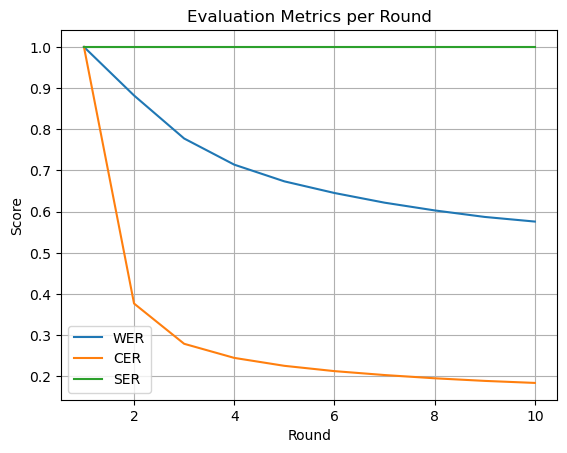

In [13]:
plt.plot(metric_df["round"], metric_df["eval_wer"], label="WER")
plt.plot(metric_df["round"], metric_df["eval_cer"], label="CER")
plt.plot(metric_df["round"], metric_df["eval_ser"], label="SER")
plt.xlabel("Round")
plt.ylabel("Score")
plt.legend()
plt.title("Evaluation Metrics per Round")
plt.grid(True)
plt.show()